In [19]:
!pip install pillow numpy torch opencv-python matplotlib seaborn torchvision tqdm scikit-learn

In [20]:
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np

In [21]:
# # Define the folders containing the images
# folders = {
#     0: "../data/Dataset/Non_Demented/",
#     1: "../data/Dataset/Very_Mild_Demented/",
#     2: "../data/Dataset/Mild_Demented/",
#     3: "../data/Dataset/Moderate_Demented/",
# }

# # Initialize lists to store the images and labels
# X = []
# y = []

# corrupted = 0

# # Iterate over the folders and load each image
# for label, path in folders.items():
#     for filename in tqdm(os.listdir(path)):
#         # Load the image
#         img_path = os.path.join(path, filename)
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         if img is None:
#             img = np.zeros((128,128))
#             corrupted += 1
#         img_tensor = torch.from_numpy(img).float() 
#         X.append(img_tensor)
#         y.append(label)

# X = torch.stack(X)
# # Normalize the images
# X = X / 255.0
# y = torch.tensor(y)

# print(X.shape, y.shape)

# torch.save(X, 'X_tensor.pt')
# torch.save(y, 'y_tensor.pt')



In [22]:
import torch
X = torch.load('X_tensor.pt')
y = torch.load('y_tensor.pt')
class_counts = y.bincount()
num_samples = y.size(0)
class_weights = 1. / class_counts

# Create a list of weights for each sample
sample_weights = class_weights[y]

# Set up the sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

# Create a dataset and a dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
# print(f'Corrupted images: {corrupted}')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # You can adjust this based on your specific needs

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders for both training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

# Starting the training and validation process
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader):  # Use train_loader for training
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():  # No gradient updates during validation
        for images, labels in tqdm(val_loader):  # Use val_loader for validation
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)
    
    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}% \n')

100%|██████████| 161/161 [00:01<00:00, 160.58it/s]


Epoch 1, Training Loss: 1.0151305816928793


100%|██████████| 41/41 [00:00<00:00, 385.57it/s]


Epoch 1, Validation Loss: 0.9232231843762282, Validation Accuracy: 55.33536585365854% 



100%|██████████| 161/161 [00:00<00:00, 167.81it/s]


Epoch 2, Training Loss: 0.8840427820726952


100%|██████████| 41/41 [00:00<00:00, 387.32it/s]


Epoch 2, Validation Loss: 0.8346034317481809, Validation Accuracy: 61.890243902439025% 



100%|██████████| 161/161 [00:00<00:00, 165.22it/s]


Epoch 3, Training Loss: 0.7398306159129054


100%|██████████| 41/41 [00:00<00:00, 383.78it/s]


Epoch 3, Validation Loss: 0.7807059709618731, Validation Accuracy: 65.2439024390244% 



100%|██████████| 161/161 [00:00<00:00, 166.63it/s]


Epoch 4, Training Loss: 0.5805819038278568


100%|██████████| 41/41 [00:00<00:00, 394.01it/s]


Epoch 4, Validation Loss: 0.7003763764642361, Validation Accuracy: 67.6829268292683% 



100%|██████████| 161/161 [00:00<00:00, 165.69it/s]


Epoch 5, Training Loss: 0.3978538256346809


100%|██████████| 41/41 [00:00<00:00, 369.31it/s]


Epoch 5, Validation Loss: 0.39646343232654946, Validation Accuracy: 83.23170731707317% 



100%|██████████| 161/161 [00:00<00:00, 166.99it/s]


Epoch 6, Training Loss: 0.22565268387335427


100%|██████████| 41/41 [00:00<00:00, 344.61it/s]


Epoch 6, Validation Loss: 0.24849787045542787, Validation Accuracy: 90.9298780487805% 



100%|██████████| 161/161 [00:00<00:00, 166.41it/s]


Epoch 7, Training Loss: 0.1597781164921612


100%|██████████| 41/41 [00:00<00:00, 394.93it/s]


Epoch 7, Validation Loss: 0.23651634311167205, Validation Accuracy: 91.84451219512195% 



100%|██████████| 161/161 [00:00<00:00, 161.24it/s]


Epoch 8, Training Loss: 0.0895578649346225


100%|██████████| 41/41 [00:00<00:00, 382.11it/s]


Epoch 8, Validation Loss: 0.13820958973431005, Validation Accuracy: 95.57926829268293% 



100%|██████████| 161/161 [00:00<00:00, 164.89it/s]


Epoch 9, Training Loss: 0.044058715687451525


100%|██████████| 41/41 [00:00<00:00, 384.54it/s]


Epoch 9, Validation Loss: 0.10733289614592384, Validation Accuracy: 96.11280487804878% 



100%|██████████| 161/161 [00:00<00:00, 166.90it/s]


Epoch 10, Training Loss: 0.029872986411578917


100%|██████████| 41/41 [00:00<00:00, 367.23it/s]

Epoch 10, Validation Loss: 0.10521871725483457, Validation Accuracy: 96.72256097560975% 



6404


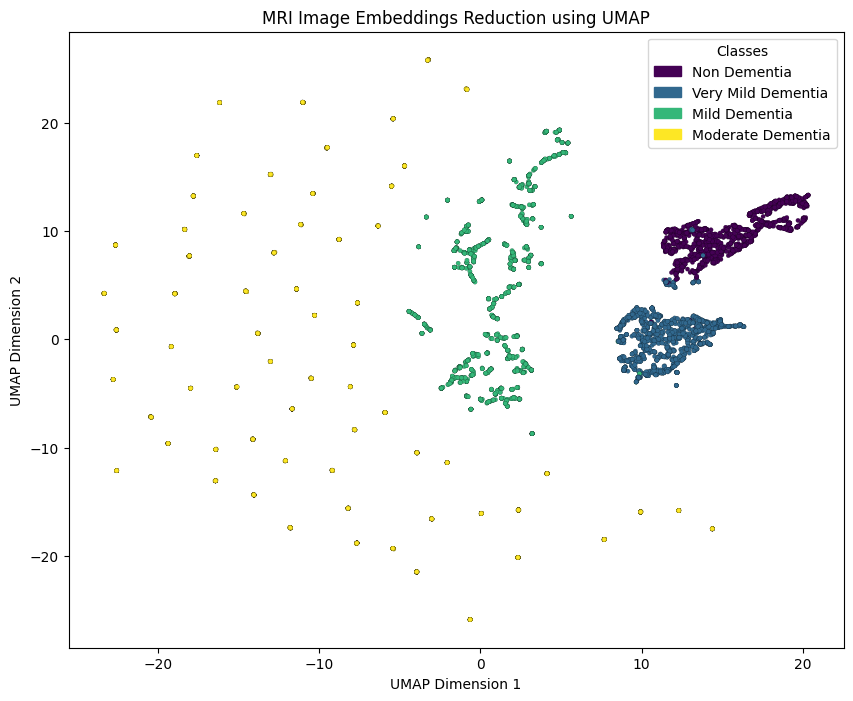

In [25]:
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.unsqueeze(1).to(device)
        emb = model(images)
        embeddings.append(emb.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.cm import plasma  # Import plasma colormap

labels_to_class = {
0: "Non Dementia",
1: "Very Mild Dementia",
2: "Mild Dementia",
3: "Moderate Dementia",
}
print(len(embeddings))

# Perform UMAP reduction
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embeddings)
cmap = plt.cm.viridis

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels_list, cmap=cmap, s=10, edgecolor='black', linewidth=0.1)
# Create a legend
legend_handles = [mpatches.Patch(color=cmap(i / (len(labels_to_class) - 1)), label=labels_to_class[i]) for i in labels_to_class]
plt.legend(handles=legend_handles, title="Classes")

plt.title('MRI Image Embeddings Reduction using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()